In [1]:
from datetime import datetime 
from pathlib import Path
import json
import numpy as np
import torch
from torch import Tensor
import pandas as pd
from typing import Tuple
from tqdm import tqdm
from shutil import copyfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from common import haversine_cluster, str_contains_sub, haversine_np, RADIUS_EARTH_KM, normalize_lat_long
from models import MlpTriangulationModel, mmles_np
from loss import DisMaxLossSecondPart
from calibration import get_calibrated_temperature
from uncertainty import ECELoss

In [2]:
# df = pd.read_csv("data/mappers_processed.csv")
df = pd.read_csv("data/mappers_processed_20230212-154020.csv")
if "id" in df.columns:
    df = df.drop(["id"], axis=1)

In [3]:
fpath_clusters = "data/clusters_sfbay_20230212-162244.csv"
df_clusters = pd.read_csv(fpath_clusters)

In [4]:
# Limit data points to those that fall within the clusterable regions
lat_bounds = [df_clusters["cluster_lat"].min(), df_clusters["cluster_lat"].max()]
long_bounds = [df_clusters["cluster_long"].min(), df_clusters["cluster_long"].max()]

for prefix in {"target", "hotspot1", "hotspot2", "hotspot3"}:
    df = df[df[f"{prefix}_lat"] > min(lat_bounds)]
    df = df[df[f"{prefix}_lat"] < max(lat_bounds)]
    df = df[df[f"{prefix}_long"] > min(long_bounds)]
    df = df[df[f"{prefix}_long"] < max(long_bounds)]

In [5]:
df.shape

(401402, 28)

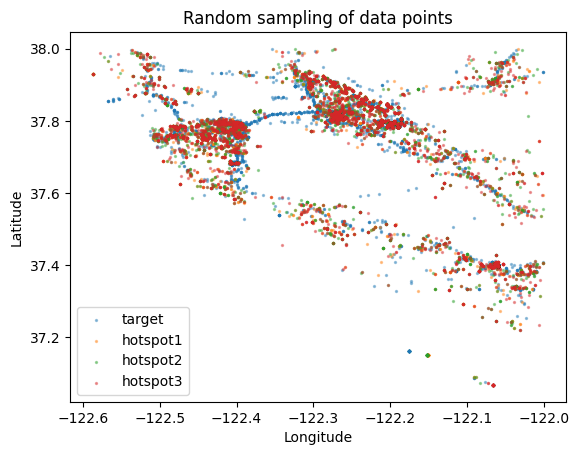

In [6]:
subset = df.sample(n=min(len(df), 5000))
for prefix in ["target"] + [f"hotspot{i}" for i in range(1,4)]:
    plt.scatter(subset[f"{prefix}_long"], subset[f"{prefix}_lat"], s=2, alpha=0.4, label=f"{prefix}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Random sampling of data points")
plt.legend()

In [7]:
if "naive_tri_alt" in df.columns:
    df = df.rename(columns={"naive_tri_alt": "naive_tri_altitude"})

In [8]:
# Add cluster assignments and their normalized values
for prefix in ["target", "hotspot1", "hotspot2", "hotspot3", "centroid_projected", "naive_tri"]:
    # Assign a cluster_id
    df[f"{prefix}_cluster_id"] = haversine_cluster(
        points_lat_long_deg=df[[f"{prefix}_lat", f"{prefix}_long"]].to_numpy(),
        centroids_lat_long_deg=df_clusters[["cluster_lat", "cluster_long"]].to_numpy(),
        trace=True,
    )
    # normalize cluster_id
    df[f"{prefix}_cluster_id_norm"] = 2 * df[f"{prefix}_cluster_id"] / (len(df_clusters) - 1) - 1

100%|██████████| 3224/3224 [00:58<00:00, 55.30it/s]


In [9]:
# Add normalized lat, long
for prefix in ["target", "hotspot1", "hotspot2", "hotspot3", "centroid_projected", "naive_tri"]:
    df[[f"{prefix}_lat_norm", f"{prefix}_long_norm"]] = normalize_lat_long(
        lat_long_deg=df[[f"{prefix}_lat", f"{prefix}_long"]].to_numpy()
    )

In [10]:
# Split the data into train and test with 80 train / 20 test
df_train, df_val = train_test_split(df, test_size=0.2, random_state = 1, shuffle=True)

In [11]:
label_cols = ["target_cluster_id"]
naive_tri_cols = ["naive_tri_cluster_id"]
sample_cols = [
        'naive_tri_cluster_id_norm', 'centroid_projected_cluster_id_norm', 'hotspot1_cluster_id_norm', 'hotspot2_cluster_id_norm', 'hotspot3_cluster_id_norm', 
        'centroid_projected_lat_norm', 'centroid_projected_long_norm',
        'hotspot1_lat_norm', 'hotspot1_long_norm', 
        'hotspot2_lat_norm', 'hotspot2_long_norm', 
        'hotspot3_lat_norm', 'hotspot3_long_norm', 
        'hotspot1_rssi', 'hotspot2_rssi', 'hotspot3_rssi', 
        'hotspot1_snr', 'hotspot2_snr','hotspot3_snr',
        # 'hotspot1_fspl_dist_km', 'hotspot2_fspl_dist_km', 'hotspot3_fspl_dist_km',
        'naive_tri_lat_norm', 'naive_tri_long_norm',
]

y_train = df_train[label_cols].to_numpy()
y_val_cluster = df_val[label_cols].to_numpy()
y_val_ll = df_val[["target_lat", "target_long"]].to_numpy()
y_val_naive_cluster = df_val[naive_tri_cols].to_numpy()
y_val_naive_ll = df_val[["naive_tri_lat", "naive_tri_long"]].to_numpy()

print(y_train.shape)
print(y_train.min(axis=0))
print(y_train.max(axis=0))
print(y_val_cluster.shape)
print(y_val_cluster.min(axis=0))
print(y_val_cluster.max(axis=0))

(321121, 1)
[1]
[3221]
(80281, 1)
[1]
[3221]


In [12]:

x_train = df_train[sample_cols].to_numpy()
x_val = df_val[sample_cols].to_numpy()

# Normalize all features to expected range -1:1 based on consideration of the training data alone
X_TRAIN_MIN = x_train.min(axis=0)
X_TRAIN_RANGE = x_train.ptp(axis=0)

for i, s in enumerate(sample_cols):
    # Avoid re-normalizing anything that was already normalized
    if str_contains_sub(s, ["_norm"]):
        continue
    print(f"Normalizing: {s}...")
    x_train[:, i] = 2 * (x_train[:, i] - X_TRAIN_MIN[i]) / X_TRAIN_RANGE[i] - 1
    x_val[:, i] = 2 * (x_val[:, i] - X_TRAIN_MIN[i]) / X_TRAIN_RANGE[i] - 1

print(x_train.shape)
print(x_train.min(axis=0))
print(x_train.max(axis=0))
print(x_val.shape)
print(x_val.min(axis=0))
print(x_val.max(axis=0))

Normalizing: hotspot1_rssi...
Normalizing: hotspot2_rssi...
Normalizing: hotspot3_rssi...
Normalizing: hotspot1_snr...
Normalizing: hotspot2_snr...
Normalizing: hotspot3_snr...
(321121, 21)
[-0.99875892 -0.99875892 -1.         -1.         -1.          0.41189941
 -0.68105594  0.41186182 -0.68106505  0.41186182 -0.68106505  0.41186182
 -0.68106505 -1.         -1.         -1.         -1.         -1.
 -1.          0.41189815 -0.68105576]
[ 1.          1.          1.          1.          1.          0.42219606
 -0.67779093  0.4222181  -0.67777814  0.4222181  -0.67777814  0.42221784
 -0.67777814  1.          1.          1.          1.          1.
  1.          0.42219604 -0.67779098]
(80281, 21)
[-0.99875892 -0.99875892 -1.         -1.         -1.          0.41189941
 -0.68103039  0.41186182 -0.68104249  0.41186182 -0.68106356  0.41186182
 -0.68106505 -1.01550388 -0.96261682 -0.95555556 -0.92265195 -1.01680668
 -0.9885057   0.41189774 -0.68103032]
[ 0.99627676  0.99627676  1.          1.   

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [14]:
torch.manual_seed(42)

Xtr, Ytr = torch.tensor(x_train).float().to(device), torch.tensor(y_train).to(device)
Xval, Yval = torch.tensor(x_val).float().to(device), torch.tensor(y_val_cluster).to(device)
Yval_NAIVE = torch.tensor(y_val_naive_cluster).float().to(device)

def get_batch(batch_size:int =32, is_train: bool=True):
    # generate a small batch of data of inputs x and targets y
    src_data = Xtr if is_train else Xval
    labels = Ytr if is_train else Yval
    ix = torch.randint(0, src_data.shape[0], (batch_size,))
    return src_data[ix], labels[ix].squeeze()

In [15]:
model = MlpTriangulationModel(
    input_size = x_train.shape[-1], # number of channels/features in each input sample
    output_size = len(df_clusters), # number of predictable clusters
)
model.to(device)

# This will replace the cross entropy loss
criterion = DisMaxLossSecondPart(model.classifier)

# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Create optimizer
init_lr = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

0.224706 M parameters


In [16]:
# Find a good learning rate
if False:
    lri = []
    lossi = []
    lre = torch.linspace(-6, -2, 1000)
    lrs = 10**lre
    BATCH_SIZE = 256
    for i, lr in enumerate(lrs):
        for g in optimizer.param_groups:
            g['lr'] = lr
        # Get a random batch
        Xb, Yb = get_batch(batch_size=BATCH_SIZE, is_train=True)

        # Predict coordinates and evaluate loss
        outputs = model(Xb)
        loss = criterion(outputs, Yb.squeeze())
        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        lri.append(lr.item())
        lossi.append(loss.item())

    plt.plot(lri, lossi)
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")

In [17]:
naive_val_acc = (Yval.squeeze() == Yval_NAIVE.squeeze()).sum().item()/Yval.size(0)
print(f"NAIVE Trilat Val Cluster Cls Acc: {100*naive_val_acc:.2f}%")

NAIVE Trilat Val Cluster Cls Acc: 4.23%


In [18]:
def get_outputs_labels_and_metrics(model, data:Tensor, labels:Tensor):
    correct = 0
    total = 0
    model.eval()
    ece_criterion = ECELoss()
    nll_criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        logits = model(data)
        output_probs = torch.nn.functional.softmax(logits,dim=1)
        max_probs, predicted = torch.max(output_probs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    nll = nll_criterion(logits, labels).item()
    ece = ece_criterion.loss(logits.cpu().numpy(),labels.cpu().numpy(),15)

    results = {}
    results['outputs'] = logits
    results['labels'] = labels
    results['acc'] = acc
    results['nll'] = nll
    results['ece'] = ece
    return results

In [19]:
# Training
BATCH_SIZE = 256
MAX_STEPS = 15000
LR_DECAY = [6000, 12000]
PRINT_INTERVAL = MAX_STEPS // 25
stats = []

lr = init_lr
for i in range(MAX_STEPS):
    model.train()
    # Get a random batch
    Xb, Yb = get_batch(batch_size=BATCH_SIZE, is_train=True)

    # Predict coordinates and evaluate loss
    outputs = model(Xb)
    loss = criterion(outputs, Yb.squeeze())

    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    step_stats = {
        "step": i,
        "loss": loss.item(),
        "lr": lr
    }
    if i % PRINT_INTERVAL == 0:
        results = get_outputs_labels_and_metrics(model, data=Xval, labels=Yval.squeeze())
        acc = results["acc"]
        ece = results["ece"]
        step_stats["val_cluster_classification_accuracy"] = acc
        step_stats["ece"] = ece
        step_stats["nll"] = results["nll"]
        print(f"Step: {i},\t Loss: {loss.item():.6f},\t [Cluster Classification] Acc: {acc:.2f}%, ECE: {ece: .2f}")
        # with torch.no_grad():
        #     classification_accuracy = eval_accuracy(data=Xval, labels=Yval.squeeze())
        #     step_stats["val_cluster_classification_accuracy"] = classification_accuracy
        # print(f"Step: {i},\t Loss: {loss.item():.6f},\tVal Cluster Cls Acc: {100*classification_accuracy:.2f}%")
    if i in LR_DECAY:
        print("Adjusting LR")
        for g in optimizer.param_groups:
            lr = lr * 0.1
            g['lr'] *= 0.1
    stats.append(step_stats)


Step: 0,	 Loss: 8.445133,	 [Cluster Classification] Acc: 0.00%, ECE:  0.00
Step: 600,	 Loss: 3.665515,	 [Cluster Classification] Acc: 29.76%, ECE:  0.30
Step: 1200,	 Loss: 2.748781,	 [Cluster Classification] Acc: 30.62%, ECE:  0.31
Step: 1800,	 Loss: 2.237001,	 [Cluster Classification] Acc: 29.19%, ECE:  0.29
Step: 2400,	 Loss: 2.519295,	 [Cluster Classification] Acc: 29.84%, ECE:  0.30
Step: 3000,	 Loss: 2.296312,	 [Cluster Classification] Acc: 27.50%, ECE:  0.27
Step: 3600,	 Loss: 2.385853,	 [Cluster Classification] Acc: 27.77%, ECE:  0.28
Step: 4200,	 Loss: 2.369025,	 [Cluster Classification] Acc: 28.28%, ECE:  0.28
Step: 4800,	 Loss: 2.171619,	 [Cluster Classification] Acc: 39.67%, ECE:  0.40
Step: 5400,	 Loss: 1.850010,	 [Cluster Classification] Acc: 32.93%, ECE:  0.33
Step: 6000,	 Loss: 1.816020,	 [Cluster Classification] Acc: 27.11%, ECE:  0.27
Adjusting LR
Step: 6600,	 Loss: 1.977454,	 [Cluster Classification] Acc: 55.88%, ECE:  0.56
Step: 7200,	 Loss: 1.987032,	 [Cluster Class

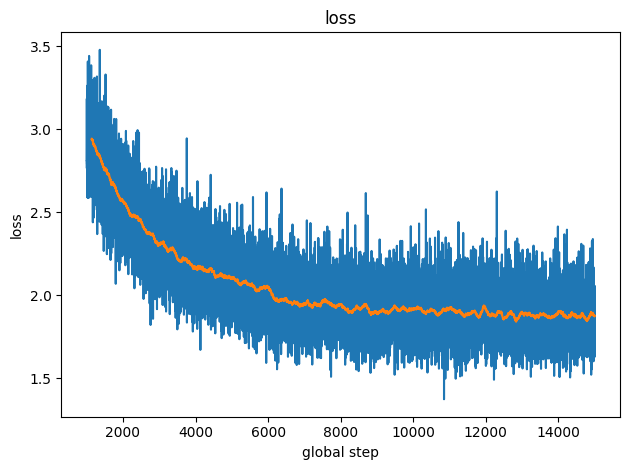

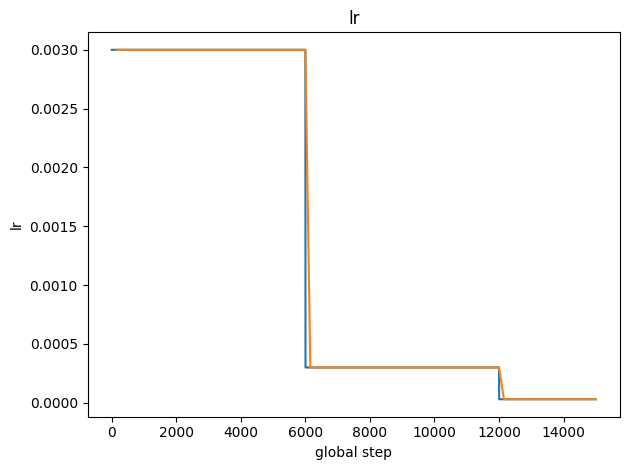

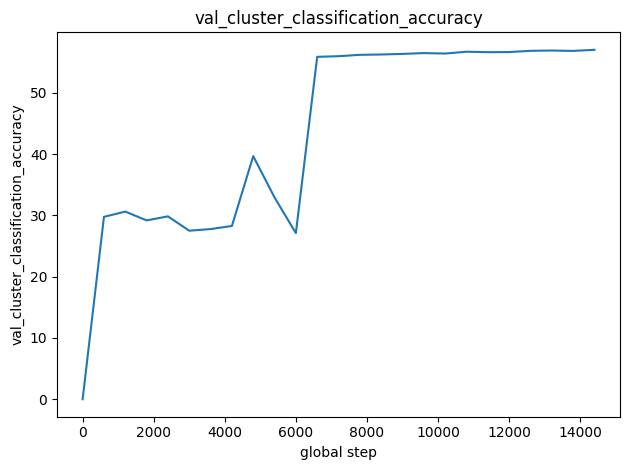

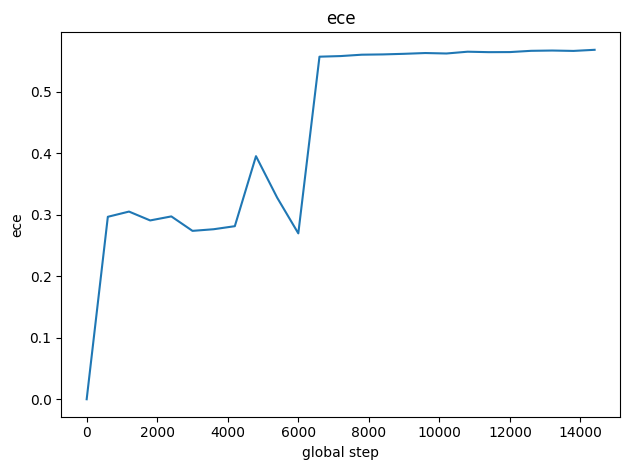

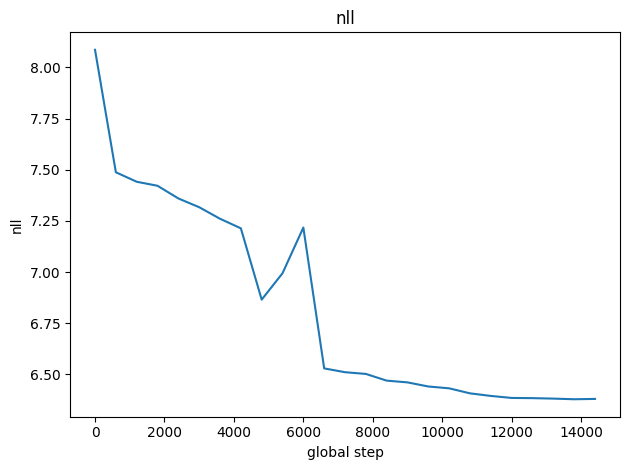

In [20]:
plot_contents = {}
for i, step_stats in enumerate(stats):
    step = step_stats.get("step", i)
    for k, v in step_stats.items():
        if k == "step":
            continue
        if k not in plot_contents:
            plot_contents[k] = {"x": [], "y":[]}
        plot_contents[k]["x"].append(step)
        plot_contents[k]["y"].append(v)
for k, v in plot_contents.items():
    x, y = np.asarray(v["x"]), np.asarray(v["y"])
    if k == "loss":
        x = x[1000:]
        y = y[1000:]
    plt.figure()
    plt.title(k)
    plt.plot(x,y)
    n = y.shape[0] // 100
    if n > 10:
        smoothed = np.convolve(y, np.ones(n), 'valid') / n
        smoothed = np.average(np.lib.stride_tricks.sliding_window_view(y, n), axis=1)
        plt.plot(x[n-1:], smoothed, label="Smoothed")
    plt.xlabel("global step")
    plt.ylabel(k)
    plt.tight_layout()

# Calibrate

In [21]:
# Calibrate the temperature for the model, optimizing ECE metric
results = get_outputs_labels_and_metrics(model, data=Xval, labels=Yval.squeeze())
logits = results["outputs"].cpu().numpy()
labels = results["labels"].cpu().numpy()
temperature_for_min_ece = get_calibrated_temperature(logits, labels)
print(temperature_for_min_ece)
model.classifier.temperature.data = torch.tensor([temperature_for_min_ece]).to(device) 

0.09639462284079857


# Export

In [22]:
# Save everything needed for inference
now_str = datetime.now().strftime("%Y%m%d-%H%M%S")
output_dir = Path("models") / now_str
output_dir.mkdir(exist_ok=False)

# Save the clusters csv
copyfile(fpath_clusters, output_dir/"clusters.csv")

# Save the model
torch.save(model, output_dir/"model.pth")

# Save training stats
with open(output_dir/"training_stats.json", "w") as f:
    json.dump(stats, f)

# Save metadata
with open(output_dir/"metadata.json", "w") as f:
    json.dump({
       "zone": {
            "latitude": {
                "min": min(lat_bounds),
                "max": max(lat_bounds)
            },
            "longitude": {
                "min": min(long_bounds),
                "max": max(long_bounds)
            }
       },
       "model": {
            "output_features": label_cols,
            "input_features": sample_cols, 
            "input_normalization": {
                "input_features_min": list(X_TRAIN_MIN),
                "input_features_range": list(X_TRAIN_RANGE),
            }
       },
    }, f)

# Inference

In [23]:
# Reload the model from disk
model = torch.load(output_dir/"model.pth")
model.to(device)


MlpTriangulationModel(
  (classifier): DisMaxLossFirstPart(num_features=64, num_classes=3224)
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=21, out_features=64, bias=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=False)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=64, bias=False)
    (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=64, bias=False)
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=64, out_features=64, bias=False)
    (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    

In [24]:
model.eval()
with torch.no_grad():
    logits = model(Xval)
    softmax_scores = model.get_softmax_scores_for_logits(logits)

logits = logits.cpu().numpy()
softmax_scores = softmax_scores.cpu().numpy()
mmles_scores = mmles_np(logits)

In [25]:
predicted_cluster_idxs = softmax_scores.argmax(axis=1).squeeze()
confidence = softmax_scores.max(axis=1)

is_correct = predicted_cluster_idxs == Yval.squeeze().cpu().numpy()
print(sum(is_correct)/is_correct.shape[0])

predicted_lat_long = df_clusters[["cluster_lat", "cluster_long"]].to_numpy()[predicted_cluster_idxs, :]
dist_err_km = haversine_np(
    predicted_lat_long, 
    y_val_ll, 
    radius=RADIUS_EARTH_KM
)
naive_tri_dist_err_km = haversine_np(
    y_val_naive_ll, 
    y_val_ll, 
    radius=RADIUS_EARTH_KM
)

0.5702719198814166


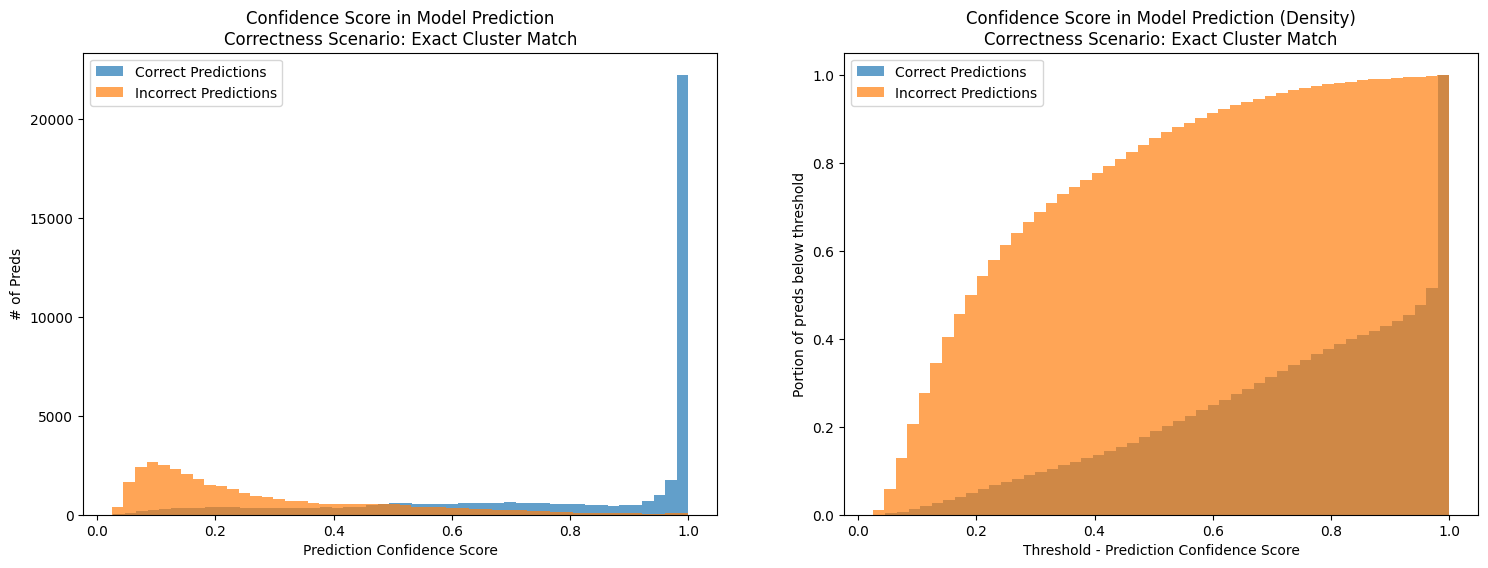

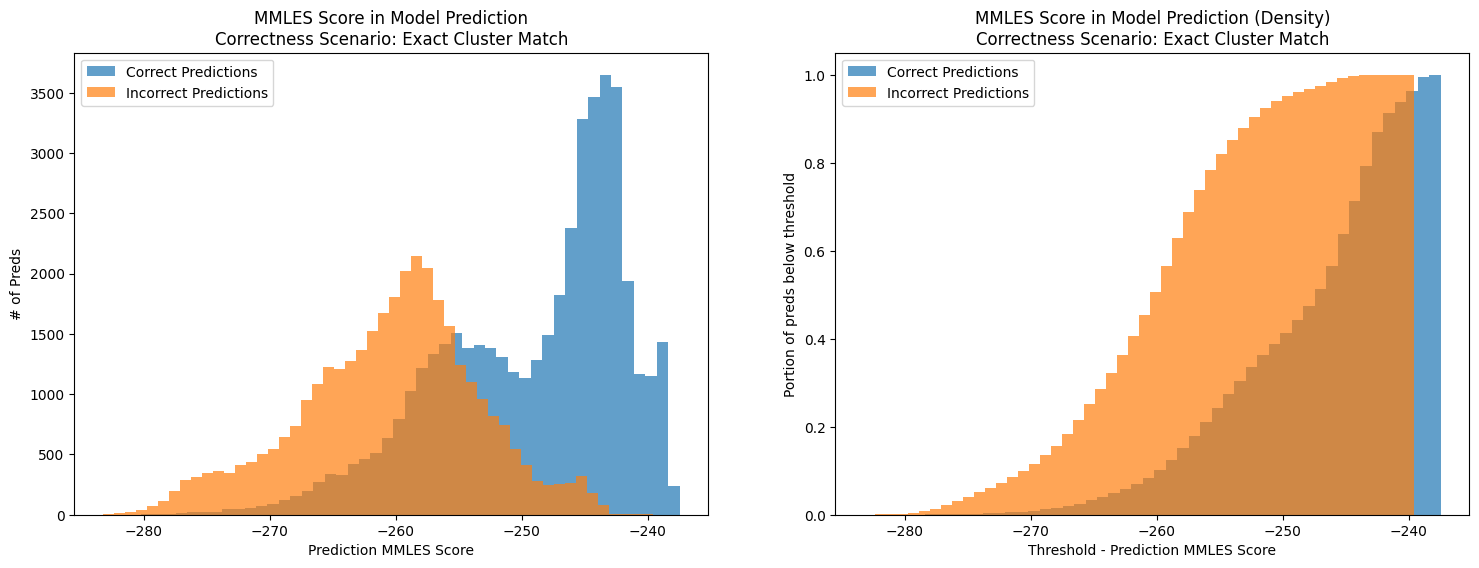

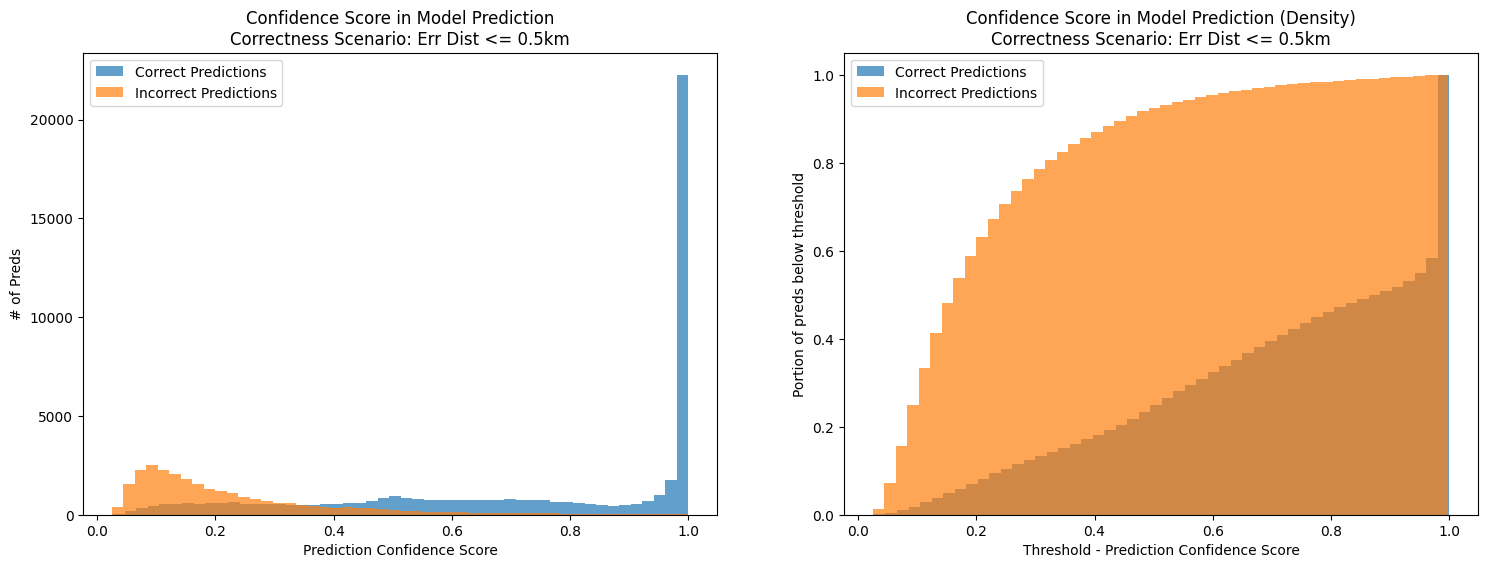

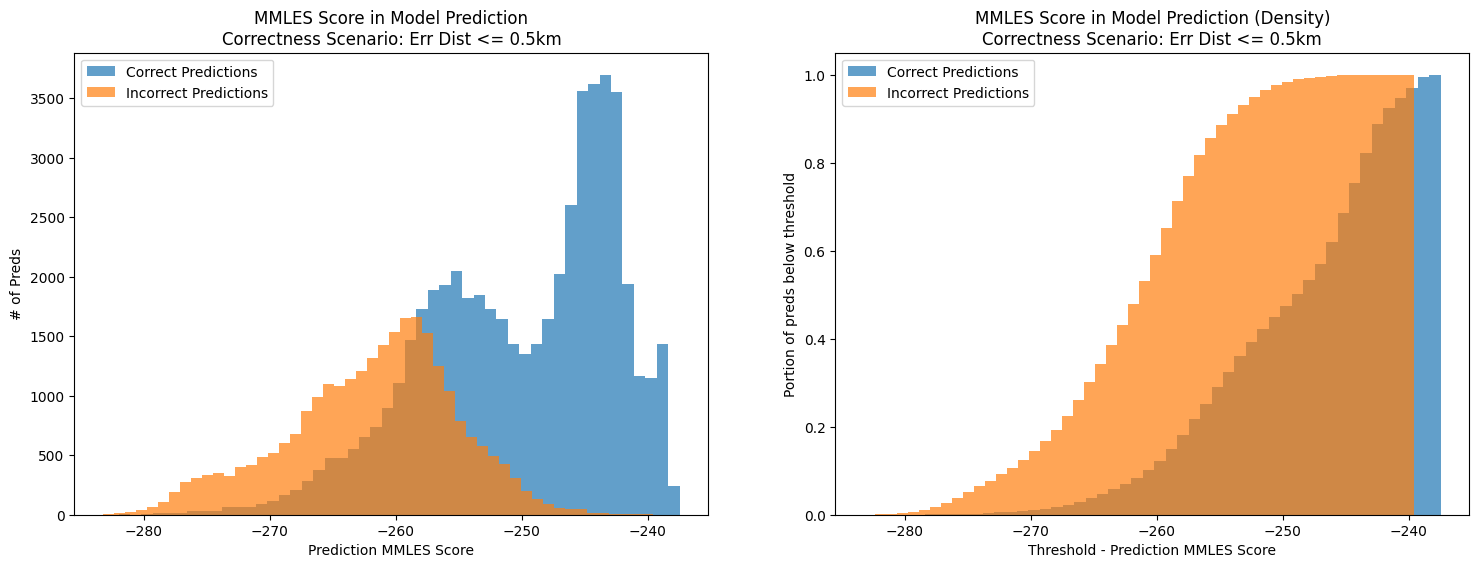

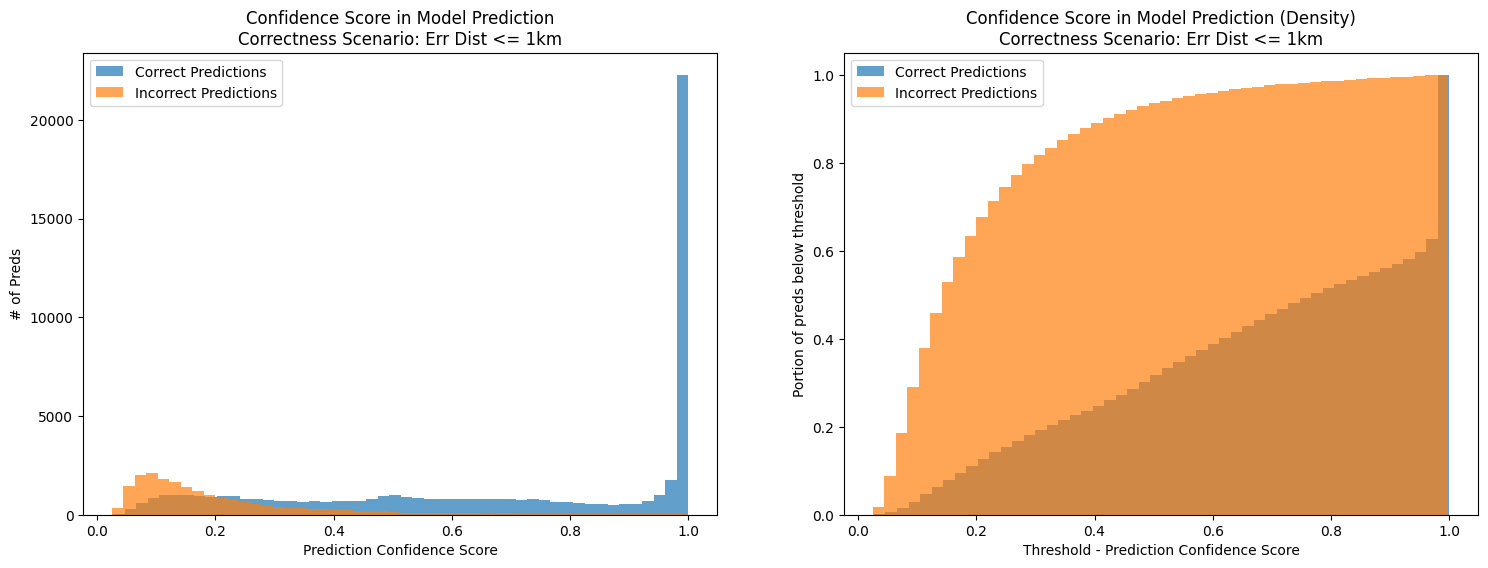

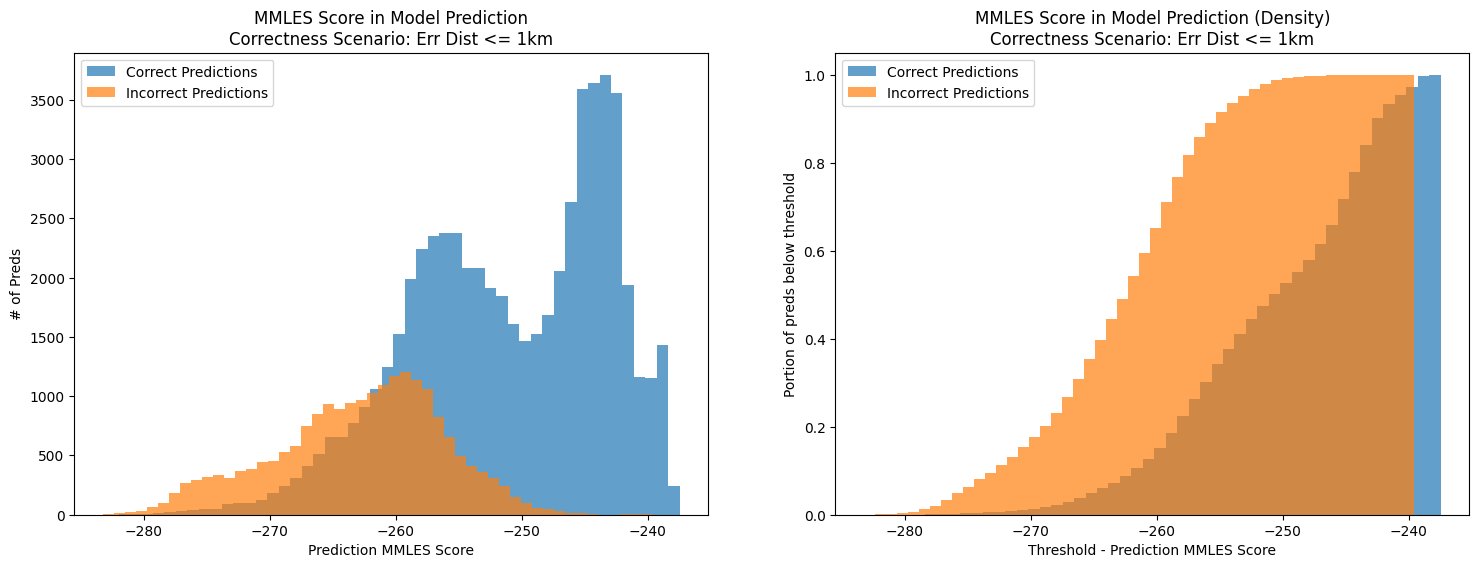

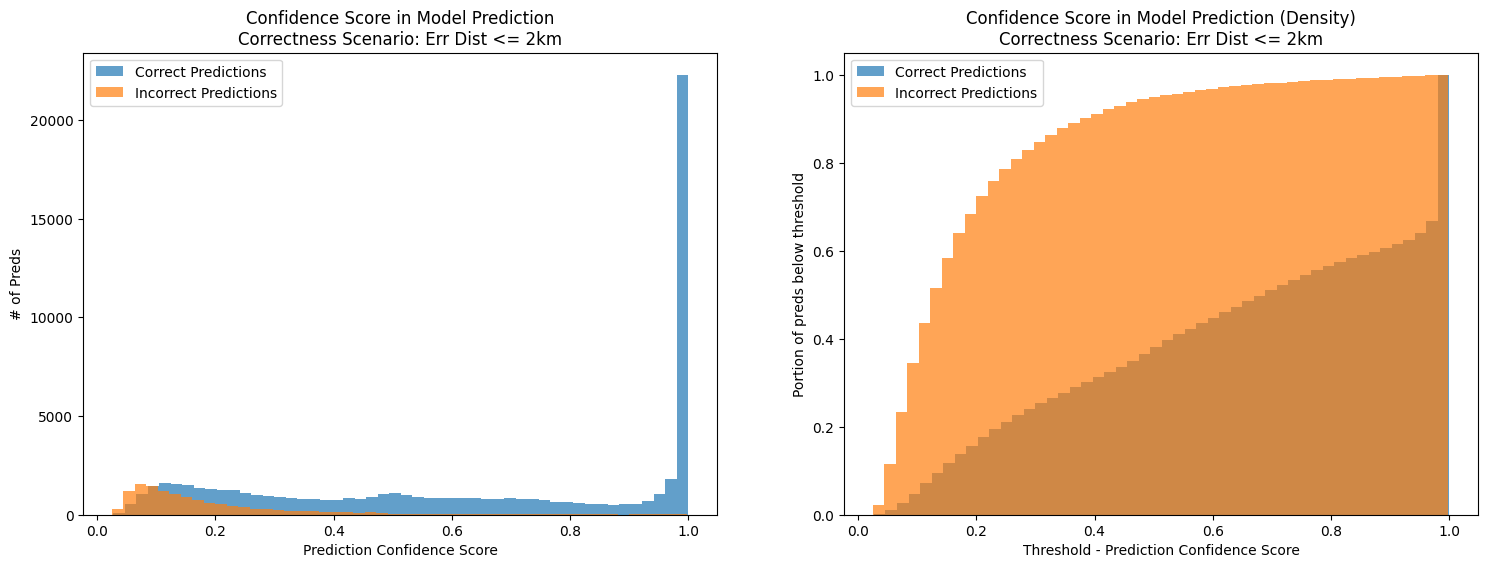

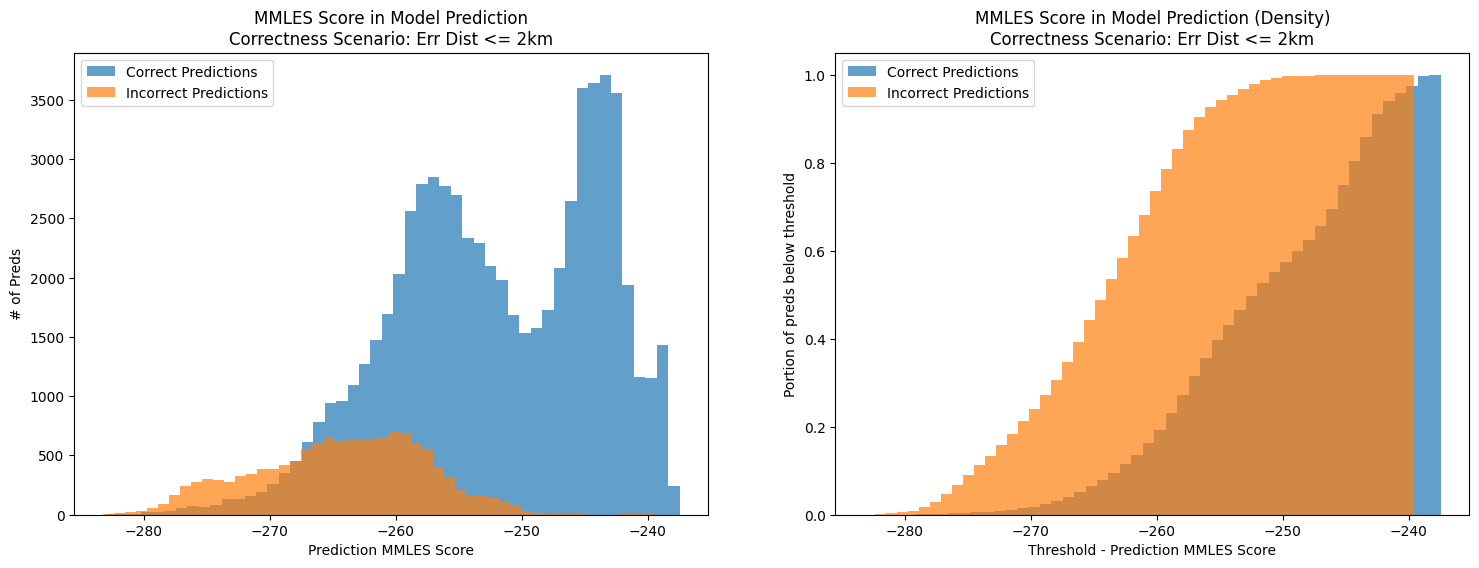

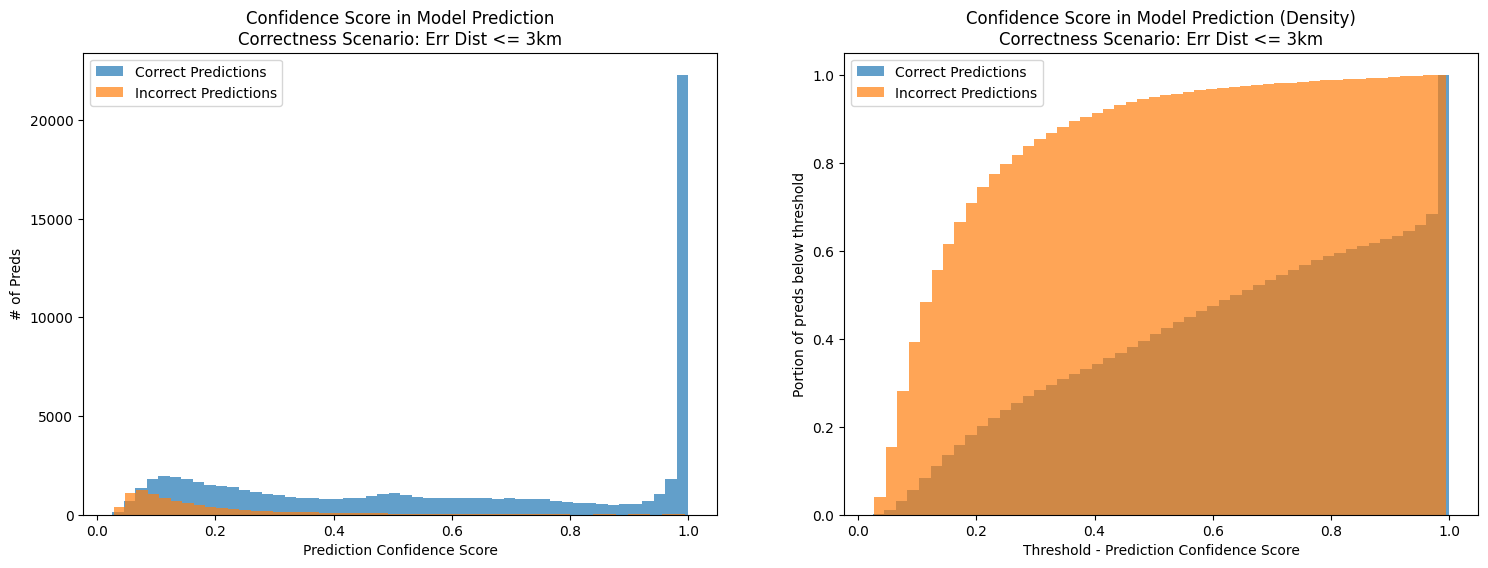

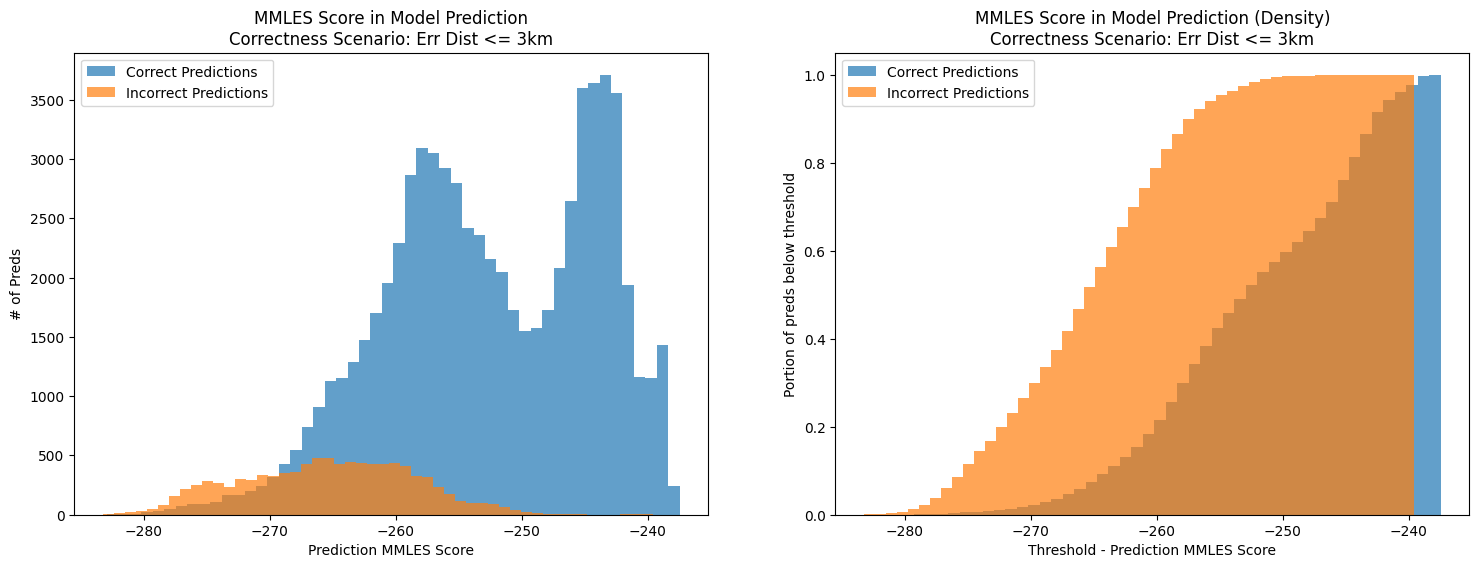

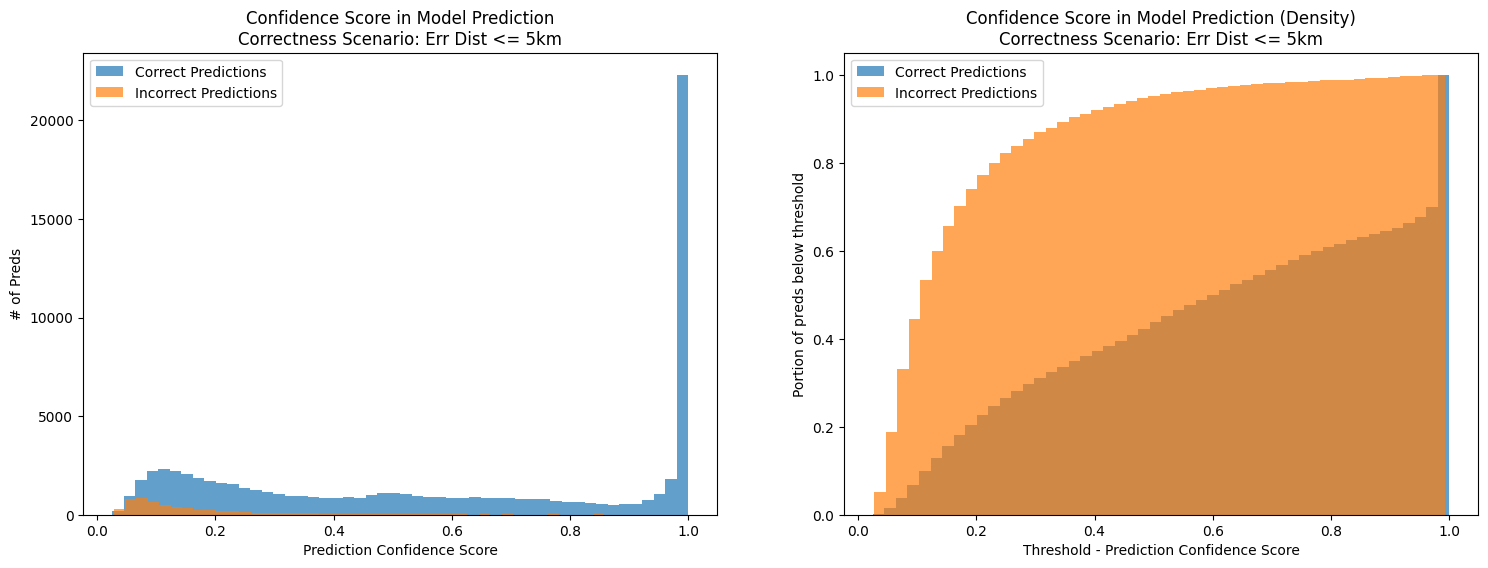

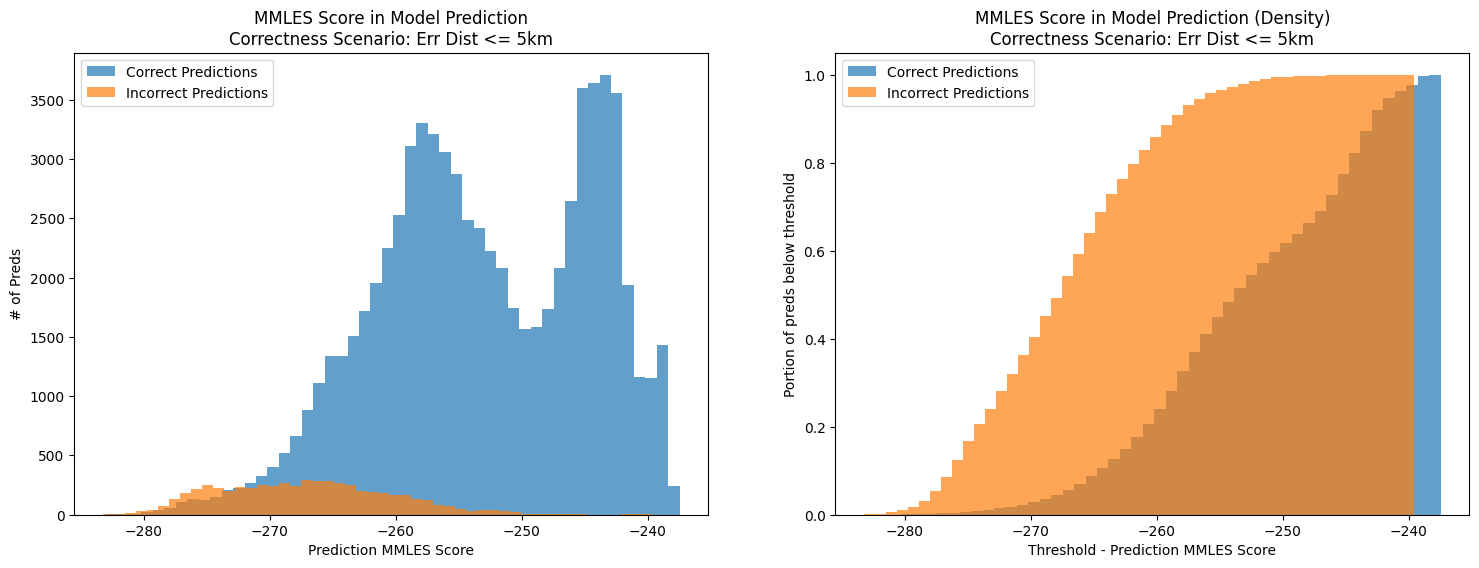

In [26]:
n_bins = 50
scenarios = [("Exact Cluster Match", is_correct)] + [(f"Err Dist <= {thresh_km}km", dist_err_km <= thresh_km) for thresh_km in (0.5, 1,2,3,5)]
for scenario_name, considered_correct in scenarios:
    for metric_name, metric in [("Confidence Score",  confidence), ("MMLES Score", mmles_scores)]:
        fig = plt.figure(figsize=(18,6))
        ax = fig.add_subplot(1,2,1)
        ax.hist(metric[considered_correct], bins=n_bins, alpha=0.7, label="Correct Predictions")
        ax.hist(metric[np.invert(considered_correct)], bins=n_bins, alpha=0.7, label="Incorrect Predictions")
        ax.set_title(f"{metric_name} in Model Prediction\nCorrectness Scenario: {scenario_name}")
        ax.set_xlabel(f"Prediction {metric_name}")
        ax.set_ylabel("# of Preds")
        ax.legend()

        ax = fig.add_subplot(1,2,2)
        ax.hist(metric[considered_correct], bins=n_bins, density=True, cumulative=True, alpha=0.7, label="Correct Predictions")
        ax.hist(metric[np.invert(considered_correct)], bins=n_bins, density=True, cumulative=True, alpha=0.7, label="Incorrect Predictions")
        ax.set_title(f"{metric_name} in Model Prediction (Density)\nCorrectness Scenario: {scenario_name}")
        ax.set_xlabel(f"Threshold - Prediction {metric_name}")
        ax.set_ylabel("Portion of preds below threshold")
        ax.legend()
        plt.show()


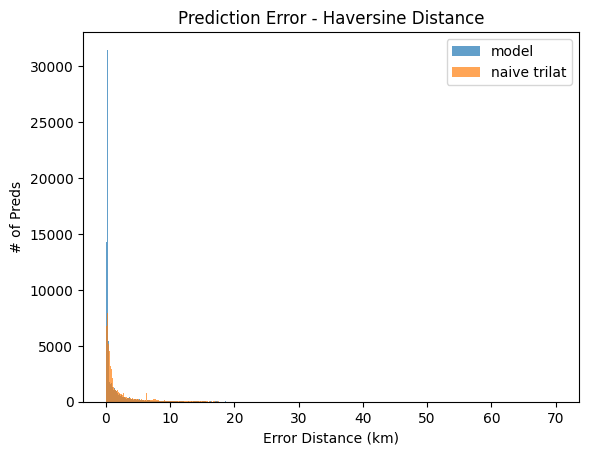

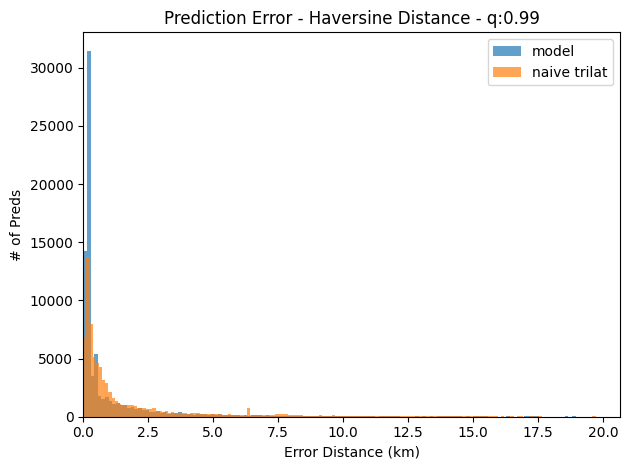

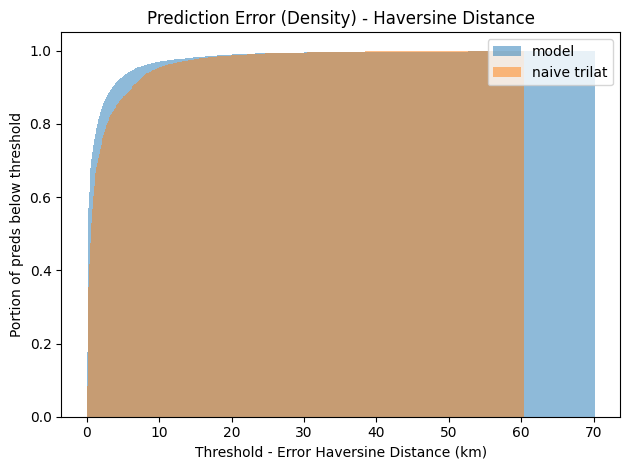

In [27]:
# Look at distribution:
n_bins = 500
plt.hist(dist_err_km, bins=n_bins, alpha=0.7, label="model")
plt.hist(naive_tri_dist_err_km, bins=n_bins, alpha=0.7, label="naive trilat")
plt.title("Prediction Error - Haversine Distance")
plt.xlabel("Error Distance (km)")
plt.ylabel("# of Preds")
# plt.tight_layout()
plt.legend()
plt.show()

# Zoom in
plt.figure()
plt.hist(dist_err_km, bins=n_bins, alpha=0.7, label="model")
plt.hist(naive_tri_dist_err_km, bins=n_bins, alpha=0.7, label="naive trilat")
plt.title("Prediction Error - Haversine Distance - q:0.99")
plt.xlim(0, np.quantile(dist_err_km, 0.99))
plt.xlabel("Error Distance (km)")
plt.ylabel("# of Preds")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.title("Prediction Error (Density) - Haversine Distance")
plt.hist(dist_err_km, bins=n_bins, alpha=0.5, density=True, cumulative=True, label="model")
plt.hist(naive_tri_dist_err_km, bins=n_bins, alpha=0.5, density=True, cumulative=True, label="naive trilat")
plt.xlabel("Threshold - Error Haversine Distance (km)")
plt.ylabel("Portion of preds below threshold")
plt.legend()
plt.tight_layout()
plt.show()